# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 216.55 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 147.64 sec


<div class="alert alert-info">
    
<strong>Answer question 1:</strong>
    
Run both approaches (RDD and DataFrame) and we can see that the DataFrame API approach is faster. The difference comes from the ability to infer the schema of DataFrame.
    
<strong>RDD</strong> is a distributed collection of data elements. It can work on both structured and unstructured data. However, in RDD user need to specify the schema of ingested data by themselves, RDD cannot infer its own. Therefore there is no inbuilt optimization engine in RDD. When working with structured data, RDDs cannot take advantages of sparks advance optimizers. 

Besides, whenever Spark needs to distribute the data within the cluster or write the data to disk, it does so use Java serialization. The overhead of serializing individual Java and Scala objects is expensive and requires sending both data and structure between nodes.
    
<strong>DataFrame</strong> is an abstraction on top of RDD in which data is organized into named columns. It can work on structured and semi-structured data. It allows Spark to manage schema which allows Spark to run certain optimizations on the finalized query. In DataFrame, optimization takes place using catalyst optimizer. Catalyst optimizer works on query plan in different phases: analysis, logical plan, physical plan and code generation.
    
Spark DataFrame can serialize the data into off-heap storage (in memory) in binary format and then perform many transformations directly on this off heap memory because spark understands the schema. 
</div>

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns
import calendar

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [7]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [12]:
#count distinct origin airports and destination airports
print("There are", df.select('src_airport').distinct().count(), "origin airports.")
print("There are", df.select('dest_airport').distinct().count(), "destination airports")

There are 224 origin airports.
There are 225 destination airports


The difference in the number of origin airports and destination airports indicates that there is at least one airport which has no flights departing from. 

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [13]:
#count distinct carriers
print("There are", df.select('carrier').distinct().count(), "unique carriers")

There are 10 unique carriers


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [14]:
night_flights = df.filter("scheduled_departure_time > 1800 or scheduled_departure_time < 600").count()
print("There are", str(night_flights), "night flights.")

There are 1121918 night flights.


In [15]:
percentage_night_filght = night_flights * 100 / df.count()
print("The percentage of night flights over the total volume of flights: ", percentage_night_filght, "%")

The percentage of night flights over the total volume of flights:  21.658447952605844 %


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [15]:
#count flights group by/orderby month
flights_by_month = df.groupBy("month").count().orderBy('month', ascending=1).collect()
flights_by_month

[Row(month=1, count=423861),
 Row(month=2, count=386954),
 Row(month=3, count=435516),
 Row(month=4, count=420995),
 Row(month=5, count=436432),
 Row(month=6, count=426490),
 Row(month=7, count=443736),
 Row(month=8, count=451086),
 Row(month=9, count=430861),
 Row(month=10, count=449369),
 Row(month=11, count=428227),
 Row(month=12, count=446521)]

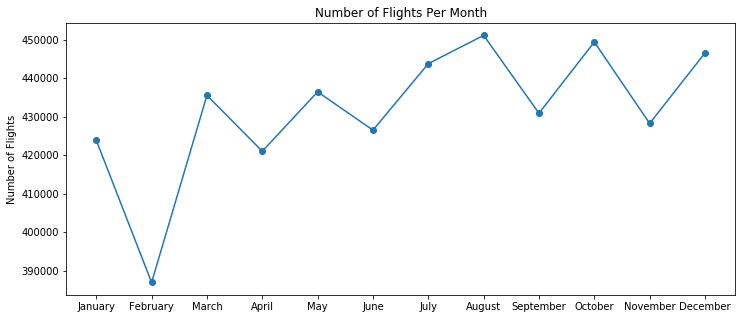

In [16]:
# get nymber of flights per month
count = [item[1] for item in flights_by_month]
month = [item[0] for item in flights_by_month]
# plot the figure
plt.figure(figsize=(12,5))
plt.plot(month, count, "-o")

plt.ylabel("Number of Flights")
plt.title("Number of Flights Per Month")
plt.xticks(month, calendar.month_name[1:13])
plt.show()

<div class="alert alert-info">
    <h3>Answer question 3.1</h3>
The figure shown that the number of flights per month fluctuates around 380,000 to 450,000. The number of flights in 31-day months (Jan, Mar, May, Jul, Aug, Oct, Dec) is higher than other months (Feb, Apr, Jun, Sep, Nov). The number of flights in February is an exception with the lowest number, less than 390,000. It's resonable because this is the shortest month in year. The number of flights per day is lightly increased in the second half of the year. Therefore we can predict that July, August, September, October, November, December are most likely to have flights experiencing delays.
</div>

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [35]:
DAY_NAME = calendar.day_name[0:7]
count

[754636, 695245, 756864, 751531, 751537, 713703, 756532]

[Row(day_of_week=1, count=754636),
 Row(day_of_week=6, count=695245),
 Row(day_of_week=3, count=756864),
 Row(day_of_week=5, count=751531),
 Row(day_of_week=4, count=751537),
 Row(day_of_week=7, count=713703),
 Row(day_of_week=2, count=756532)]

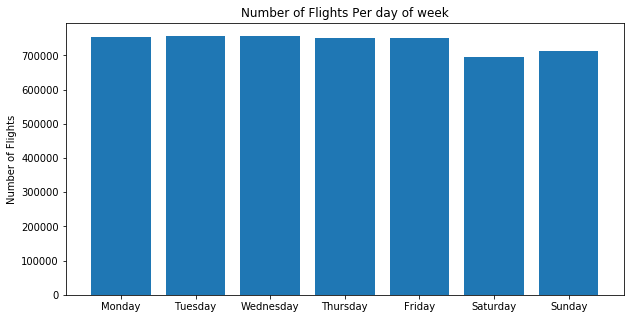

In [34]:
#count the number of flights group by day_of_week
flights_per_day_of_week = df.groupBy("day_of_week").count().collect()
display(flights_per_day_of_week)
count = [item[1] for item in flights_per_day_of_week]
day_of_week = [item[0] for item in flights_per_day_of_week]

#plot data
plt.figure(figsize=(10,5))
plt.bar(day_of_week, count, align="center")
plt.xticks(day_of_week, [DAY_NAME[(_ - 1)] for _ in day_of_week])
plt.ylabel("Number of Flights", fontsize = 10)
plt.title("Number of Flights Per day of week")
plt.show()

<div class="alert alert-info">
    <h3>Answer question 3.2</h3>
    According to the global aggregates on the number of flights per day of week, it is obvious that the number of flights is stable on weekdays. There are fewer flights during the weekends.
</div>

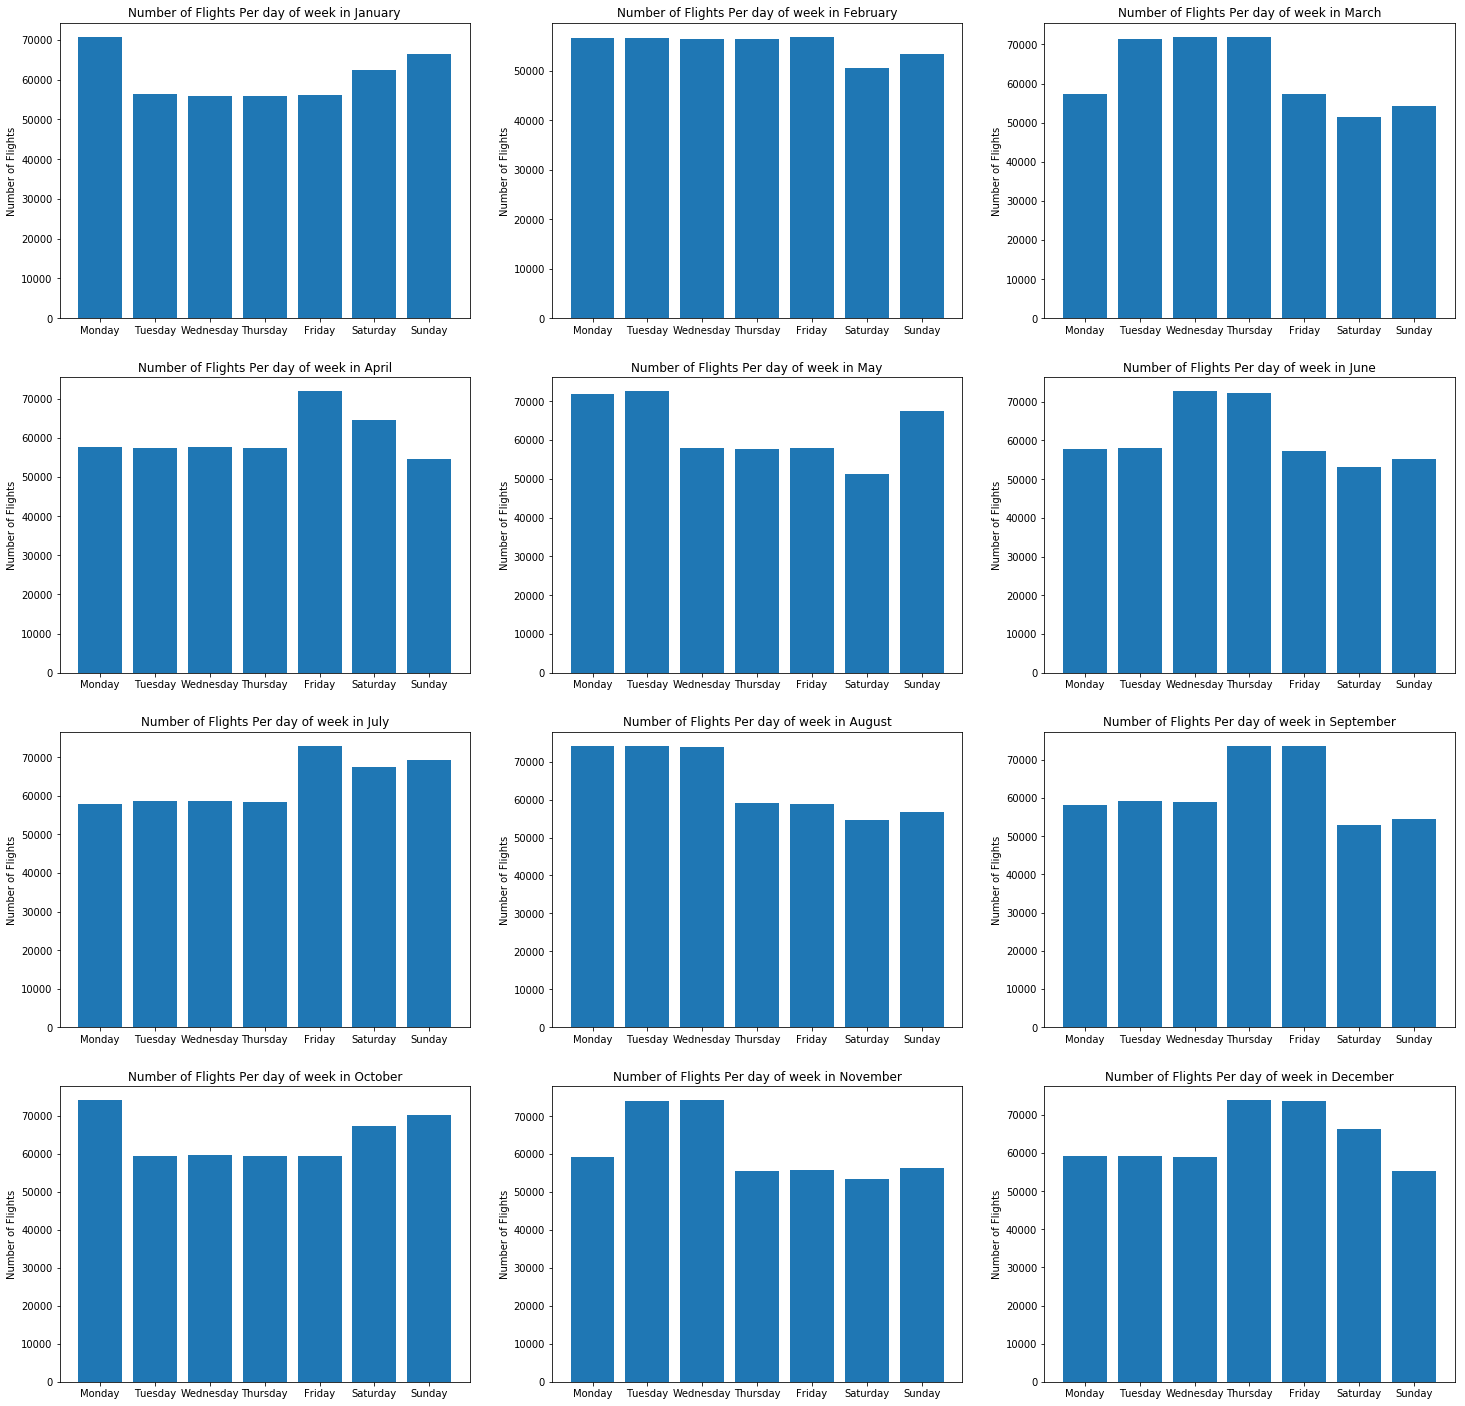

In [36]:
#display 3 months in each row
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nr, nc, i+1)
    #count number of flights per day of week for monthly aggregates
    flights_per_day_of_week = df[df.month == (i + 1)].groupBy("day_of_week").count().collect()
    count = [item[1] for item in flights_per_day_of_week]
    day_of_week = [item[0] for item in flights_per_day_of_week]
    
    #plot data
    plt.bar(day_of_week, count, align="center")
    plt.xticks(day_of_week, [DAY_NAME[(_ - 1)] for _ in day_of_week])
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights Per day of week in " + calendar.month_name[i + 1])
plt.show()

<div class="alert alert-info">
    Comparing monthly aggregates and global aggregates, we can see that there is a different ratio between the number of flights on weekdays and weekends. Accroding to the global aggregates, it seems that the number of flights in weekdays are similar while there is fewer flights during the weekends. Accroding to monthly aggregates, this rule is not really proper. The number of flights on weekends now is higher in some months, for example, January, May, July, October, December. The number of flights on weekdays is not is stable in each month too. <strong>However we can see that for each month, there are around 2 - 3 days of week which have more flights than others.</strong> It is resonable because except Feb, there are 30 - 31 days per month, it means that in a month there are 2 - 3 days of week which occurs more than others. Thus, the number of flights in days of week in a month also depends on how many Mon, Tue, Wed, Thu, Fri, Sat, Sun there are.
</div>

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

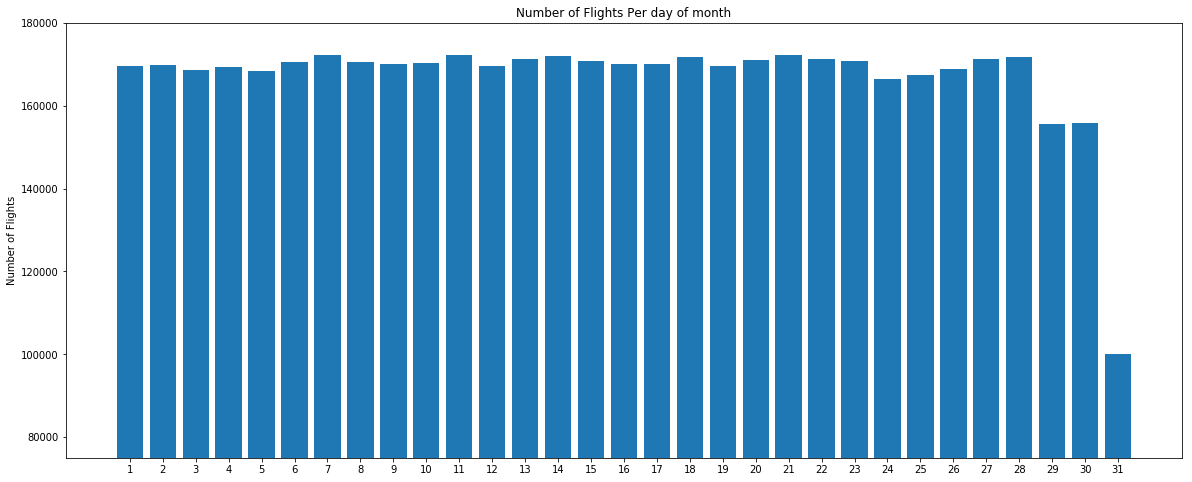

In [38]:
#count number of flights group by day_of_month
flights_per_day_of_month = df.groupBy("day_of_month").count().collect()
count = [item[1] for item in flights_per_day_of_month]
day_of_month = [item[0] for item in flights_per_day_of_month]

#plot data
plt.figure(figsize=(20,8))
plt.bar(day_of_month, count, align="center")
plt.ylabel("Number of Flights")
plt.title("Number of Flights Per day of month")
plt.xticks(day_of_month, day_of_month)
#limit range y-axis
plt.ylim([75000,180000])
plt.show()

<div class="alert alert-info">
    For global aggregates, it seems the number of flights does not change much between days of the month, except for days in the end of the month. There are fewer flights in the last 3 days (29, 30, 31). Especially the fewest one falls on the 31st because not all of months have the 31st day.
</div>

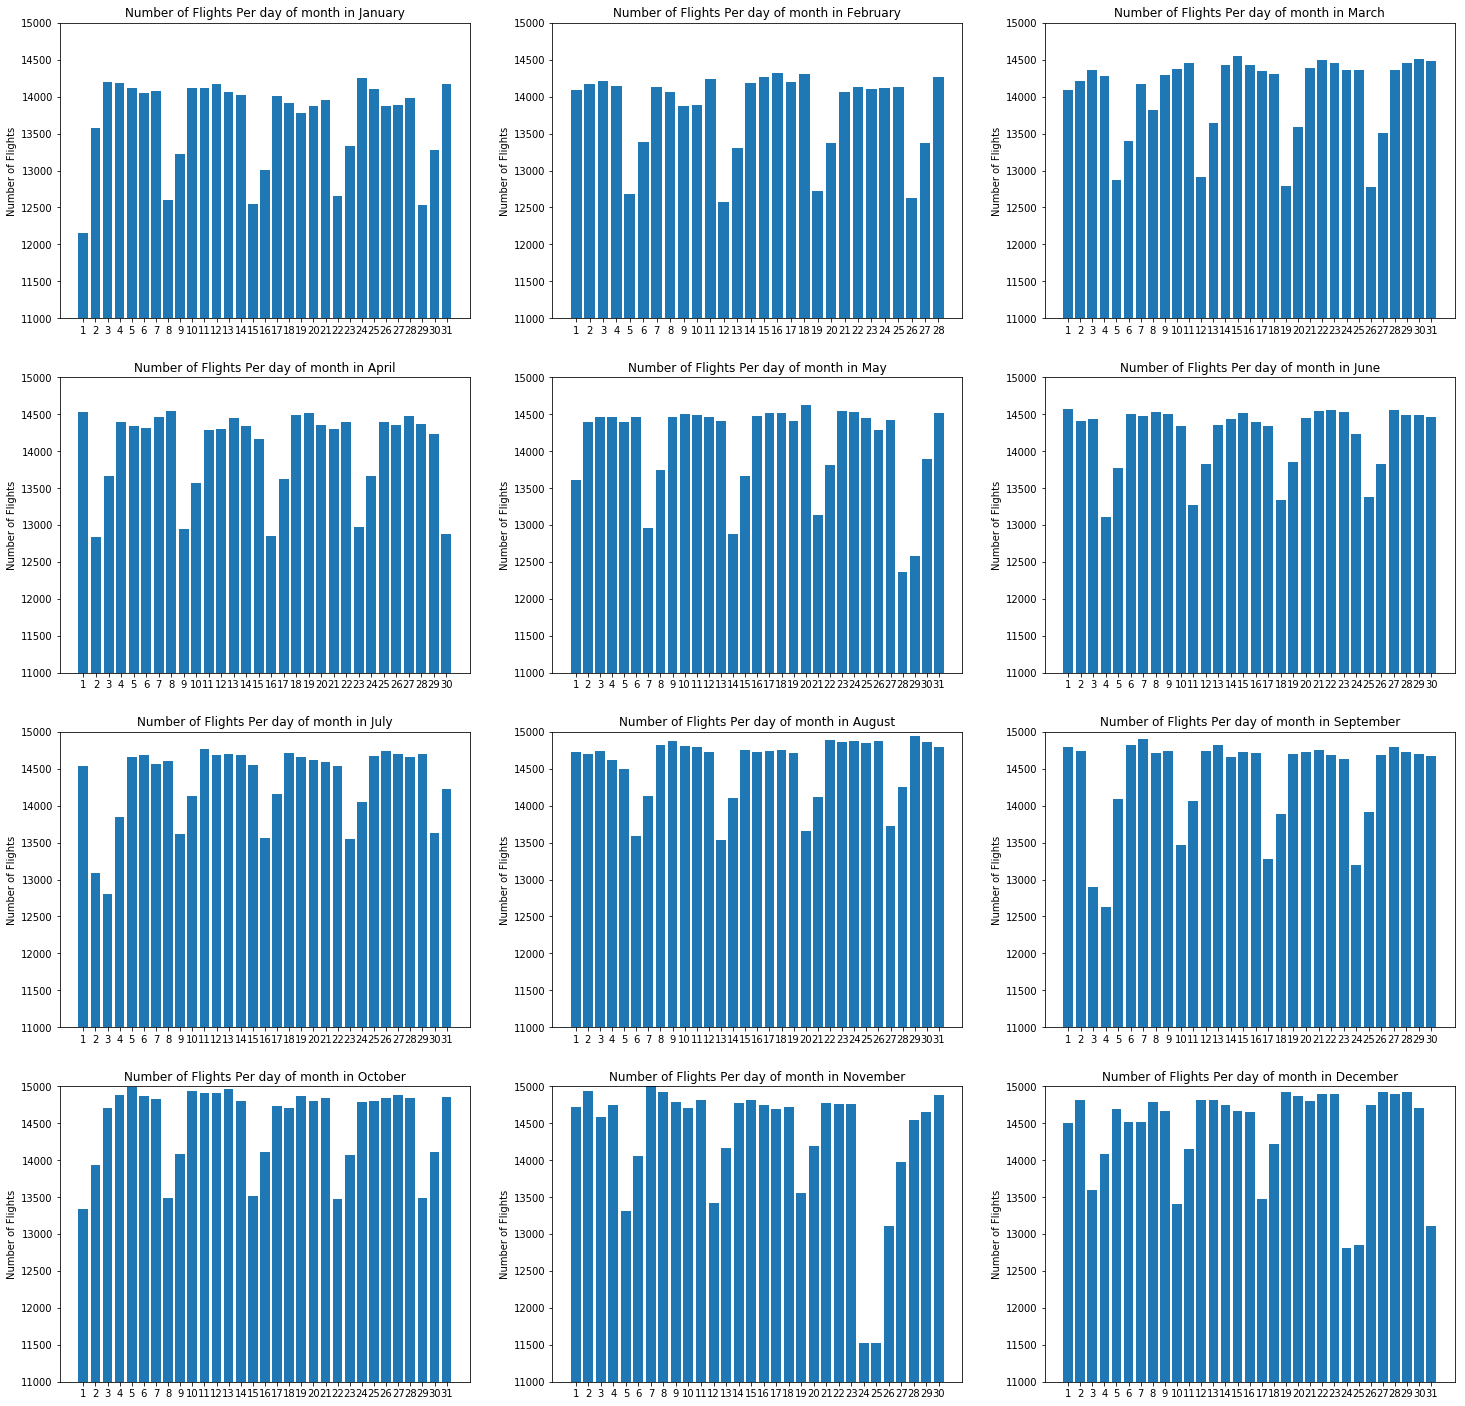

In [10]:
#display 3 months in each row
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nr, nc, i+1)
    #count number of flights per day of month for monthly aggregates
    flights_per_day_of_month = df[df.month == (i + 1)].groupBy("day_of_month").count().collect()
    count = [item[1] for item in flights_per_day_of_month]
    day_of_month = [item[0] for item in flights_per_day_of_month]
    
    #plot data
    plt.bar(day_of_month, count, align="center")
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights Per day of month in " + calendar.month_name[i + 1])
    plt.ylim([11000,15000])
    plt.xticks(day_of_month, day_of_month)
plt.show()

<div class="alert alert-info">
    
For monthly aggregates, we see that there are fewer flights in the last days of month (29, 30, 31) because months have different length.
    
For monthly aggregates, we see that the number of flights change in the period of 7 days: 3 - 4 days with high number of flights followed by 2 - 3 lower days. From what we know above, we can assume that these lower days are weekends. That's why the rule "fewer flights on weekends" is still right for months which have 4 "lower periods" like Mar, Jun, Aug, Sep, Nov.

We also notice that there are 2 days whose the number of flights is extremely low in Nov. Maybe there is some special factors which affect to those days such as storms etc.
</div>

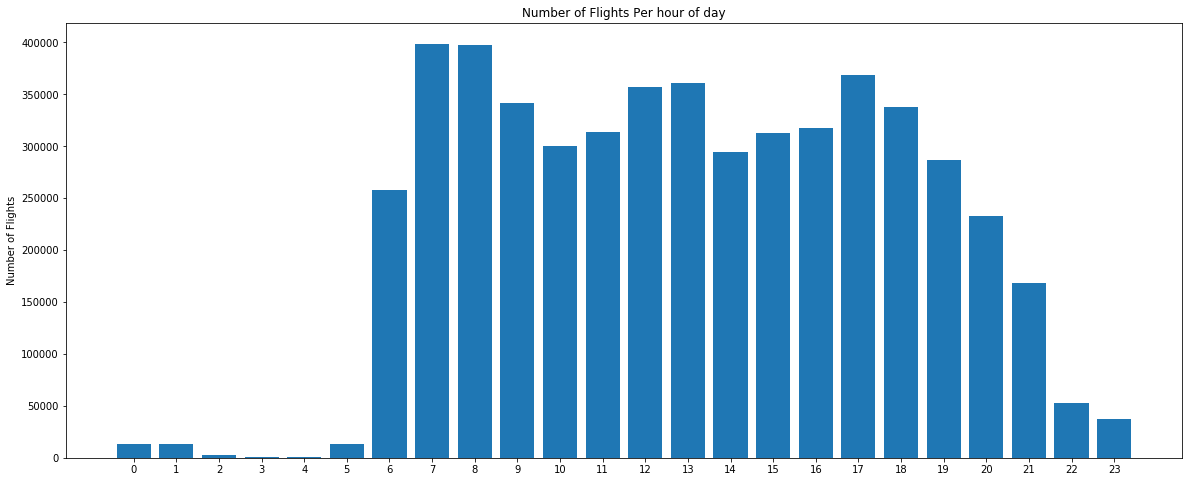

In [39]:
#count number of flight group by hour of day, convert scheduled_departure_time to hour
flights_per_hour_of_day = (df.groupBy(((df.scheduled_departure_time/100).cast('int')%24).alias('hour'))
    .count().orderBy('hour').collect())
count = [item[1] for item in flights_per_hour_of_day]
hour_of_day = [item[0] for item in flights_per_hour_of_day]

#plot data
plt.figure(figsize=(20,8))
plt.bar(hour_of_day, count, align="center")
plt.ylabel("Number of Flights")
plt.title("Number of Flights Per hour of day")
plt.xticks(hour_of_day, hour_of_day)
plt.show()

<div class="alert alert-info">
    According to the global aggregates, there are fewer flights from 21h to 5h. The most busiest time is from 7h to 8h with around 400,000 flights per hour.
</div>

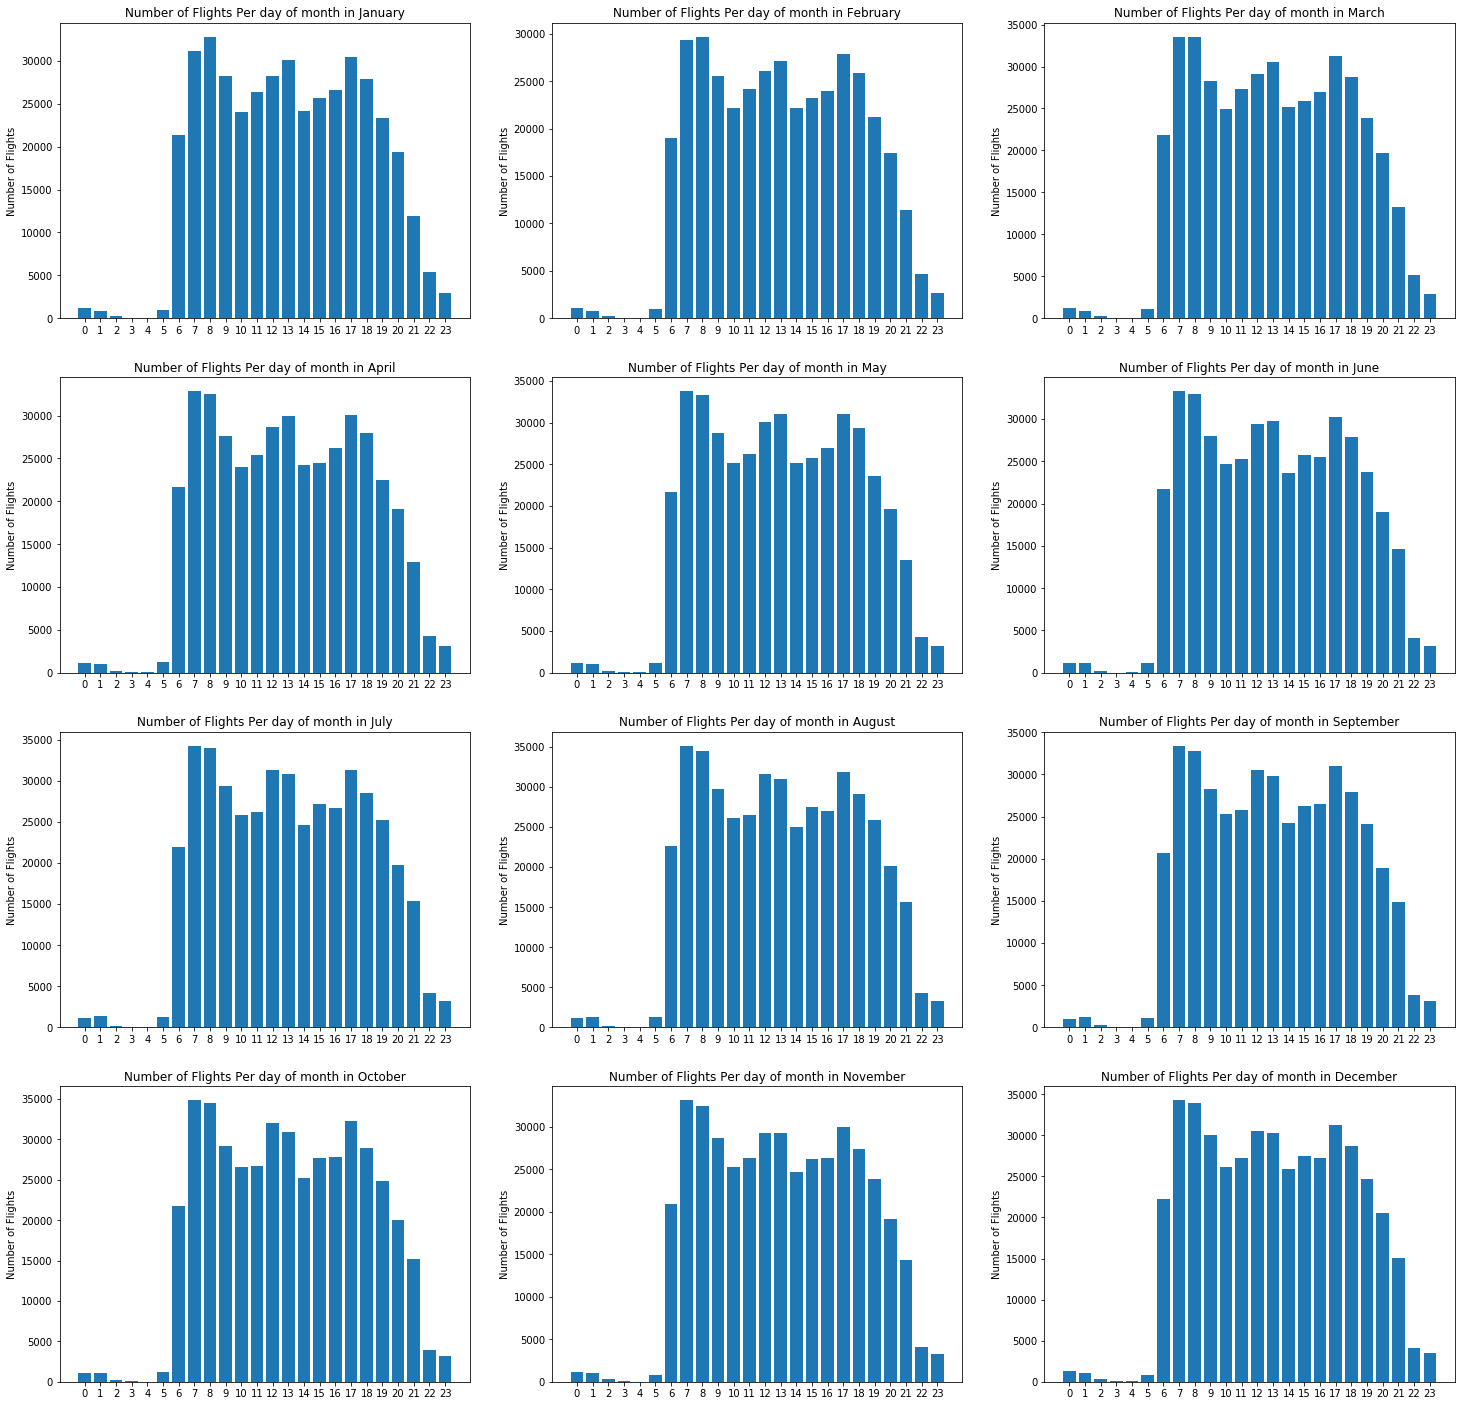

In [104]:
#display 3 months in each row
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nr, nc, i+1)
    #count number of flights per hour of day for monthly aggregates
    flights_per_hour_of_day = (df[df.month == (i + 1)].groupBy(((df.scheduled_departure_time/100).cast('int')%24).alias('hour'))
    .count().orderBy('hour').collect())
    count = [item[1] for item in flights_per_hour_of_day]
    hour_of_day = [item[0] for item in flights_per_hour_of_day]
    
    #plot data
    plt.bar(hour_of_day, count, align="center")
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights Per day of month in " + calendar.month_name[i + 1])
    plt.xticks(hour_of_day, hour_of_day)
plt.show()

<div class="alert alert-info">
    Same as the global aggregates, there are fewer flights from 21h to 5h in each month. The time from 7h to 8h or from 12h to 13h is the busiest time. Therefore, in these rush hours it is more likely to have delay flight.
</div>

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [40]:
#count outbound group by src_airport
top20_outbound = df.groupBy(df.src_airport).count().orderBy('count', ascending=0).head(20)
top20_outbound

[Row(src_airport='ORD', count=277741),
 Row(src_airport='DFW', count=256274),
 Row(src_airport='ATL', count=221486),
 Row(src_airport='LAX', count=153494),
 Row(src_airport='STL', count=151609),
 Row(src_airport='DEN', count=141427),
 Row(src_airport='PHX', count=139581),
 Row(src_airport='DTW', count=136837),
 Row(src_airport='PIT', count=130977),
 Row(src_airport='CLT', count=129391),
 Row(src_airport='MSP', count=123222),
 Row(src_airport='SFO', count=118233),
 Row(src_airport='EWR', count=116768),
 Row(src_airport='IAH', count=104182),
 Row(src_airport='LGA', count=101864),
 Row(src_airport='BOS', count=100365),
 Row(src_airport='LAS', count=94972),
 Row(src_airport='PHL', count=93585),
 Row(src_airport='DCA', count=88445),
 Row(src_airport='MCO', count=77120)]

In [41]:
#count inbound group by dest_airport
top20_inbound = df.groupBy(df.dest_airport).count().orderBy('count', ascending=0).head(20)
top20_inbound

[Row(dest_airport='ORD', count=283720),
 Row(dest_airport='DFW', count=260249),
 Row(dest_airport='ATL', count=221588),
 Row(dest_airport='LAX', count=152959),
 Row(dest_airport='STL', count=152800),
 Row(dest_airport='DEN', count=144099),
 Row(dest_airport='PHX', count=140979),
 Row(dest_airport='DTW', count=139435),
 Row(dest_airport='PIT', count=131962),
 Row(dest_airport='CLT', count=130321),
 Row(dest_airport='MSP', count=124758),
 Row(dest_airport='SFO', count=117245),
 Row(dest_airport='EWR', count=117223),
 Row(dest_airport='IAH', count=104409),
 Row(dest_airport='LGA', count=101498),
 Row(dest_airport='BOS', count=99331),
 Row(dest_airport='LAS', count=94948),
 Row(dest_airport='PHL', count=93312),
 Row(dest_airport='DCA', count=87670),
 Row(dest_airport='MCO', count=76600)]

In [42]:
#total number of flights: union column src_airport and dest_airport
df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))
#count number of flights group by the union airport
top20_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)
top20_airport.head(20)

[Row(airport='ORD', count=561461),
 Row(airport='DFW', count=516523),
 Row(airport='ATL', count=443074),
 Row(airport='LAX', count=306453),
 Row(airport='STL', count=304409),
 Row(airport='DEN', count=285526),
 Row(airport='PHX', count=280560),
 Row(airport='DTW', count=276272),
 Row(airport='PIT', count=262939),
 Row(airport='CLT', count=259712),
 Row(airport='MSP', count=247980),
 Row(airport='SFO', count=235478),
 Row(airport='EWR', count=233991),
 Row(airport='IAH', count=208591),
 Row(airport='LGA', count=203362),
 Row(airport='BOS', count=199696),
 Row(airport='LAS', count=189920),
 Row(airport='PHL', count=186897),
 Row(airport='DCA', count=176115),
 Row(airport='MCO', count=153720)]

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [43]:
top20_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0).head(20)
top20_carriers

[Row(carrier='DL', count=874526),
 Row(carrier='US', count=857906),
 Row(carrier='AA', count=722277),
 Row(carrier='UA', count=638750),
 Row(carrier='WN', count=565426),
 Row(carrier='CO', count=484834),
 Row(carrier='NW', count=482798),
 Row(carrier='TW', count=258205),
 Row(carrier='HP', count=177851),
 Row(carrier='AS', count=117475)]

<BarContainer object of 10 artists>

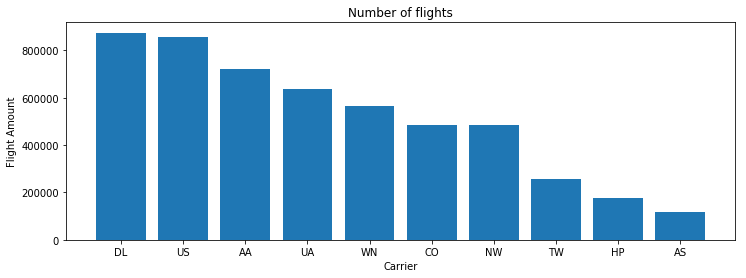

In [44]:
plt.subplots(figsize=(12,4))
plt.title("Number of flights")
plt.xlabel("Carrier")
plt.ylabel("Flight Amount")

count = [item[1] for item in top20_carriers]
hour_of_day = [item[0] for item in top20_carriers]
plt.bar(hour_of_day, count, align="center")

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [14]:
# number of flights per hour
flights_per_hour_of_day = (df.groupBy(((df.scheduled_departure_time/100).cast('int')).alias('hour'))
    .count().orderBy('hour'))

# number of delayed flights for different hours
flights_delay_hour_of_day = (df[df.arrival_delay >= 15].groupBy(((df.scheduled_departure_time/100)
    .cast('int')).alias('hour'))
    .count().alias('number_flight').orderBy('hour'))

# percentage of delayed flights
percentage_hour_delay = (
    flights_delay_hour_of_day.join(flights_per_hour_of_day, flights_delay_hour_of_day.hour == flights_per_hour_of_day.hour, 'inner')
    .select(flights_delay_hour_of_day.hour, flights_delay_hour_of_day['count']*100/flights_per_hour_of_day['count'])
    .orderBy('hour')
    .collect()
)

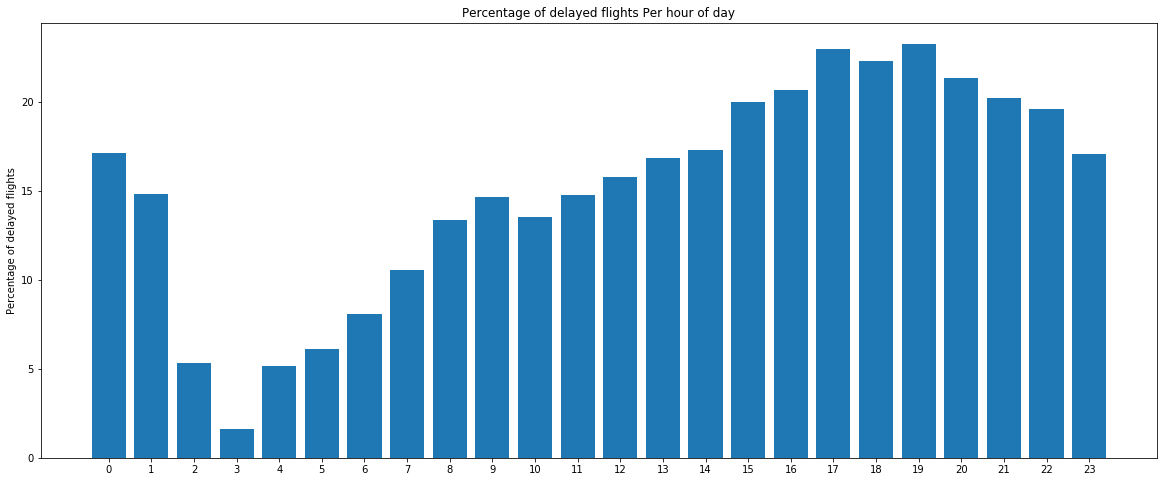

In [15]:
#plot data
percent = [item[1] for item in percentage_hour_delay]
hour_of_day = [item[0] for item in percentage_hour_delay]
plt.figure(figsize=(20,8))
plt.bar(hour_of_day, percent, align="center")
plt.ylabel("Percentage of delayed flights")
plt.title("Percentage of delayed flights Per hour of day")
plt.xticks(hour_of_day, hour_of_day)
plt.show()

<div class="alert alert-info">
    As described by the chart, the percentage of delayed flights starts to increase gradually from 4 AM, reaches the maximum values in the period 5 PM to 7 PM, and then descreases. We also notice that there are many delayed flights from 10PM to 2 AM although there is a very low number of flights in this period of time. Another observation is that the percentage of delayes flights from 3 AM - 4 AM is extremely low.
</div>

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

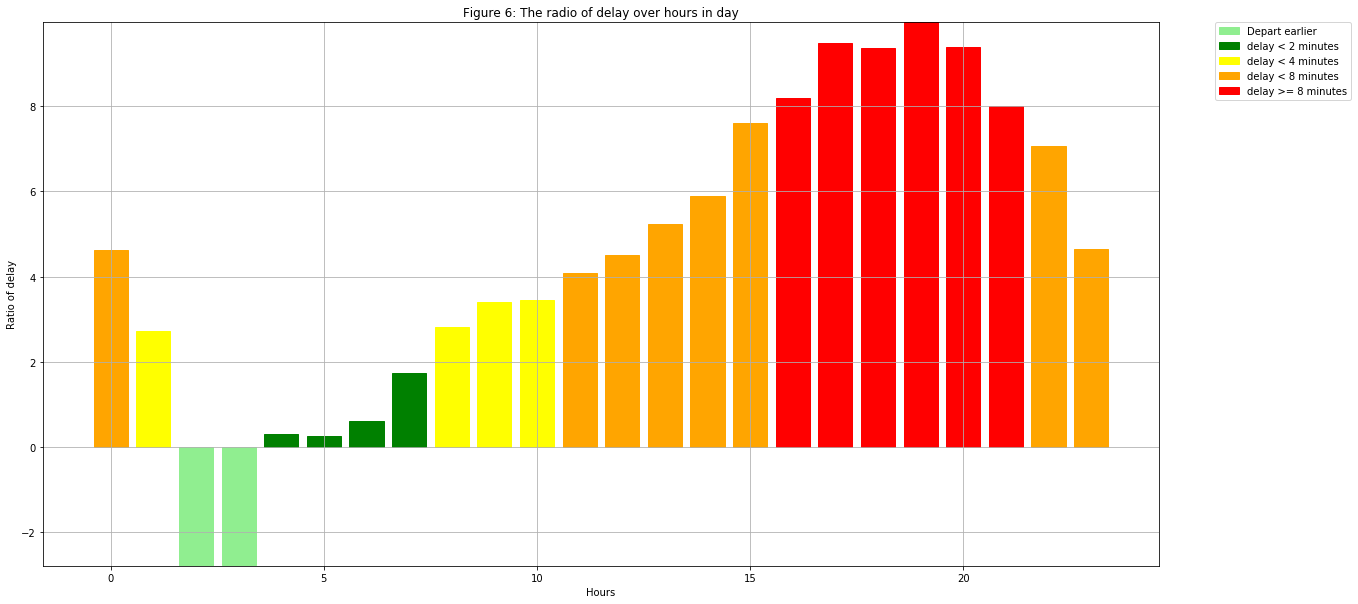

In [16]:
#count number of delayed flights group by hour and calculate the average number of delayed flights 
hour_avg_delay = (
    df.groupBy(((df.scheduled_departure_time/100)%24).cast('int').alias('hour'))
    .avg('arrival_delay')
    .orderBy('hour')
    .collect()
)
pdf_mean_delay_per_hour = [item[1] for item in hour_avg_delay]
hour_of_day = [item[0] for item in hour_avg_delay]
plt.subplots(figsize=(20,10))
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(hour_of_day, pdf_mean_delay_per_hour, align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [17]:
# number of flights per hour
flights_per_day_of_month = df.groupBy(df.day_of_month).count()

# number of delayed flights for different hours
flights_delay_day_of_month = df[df.arrival_delay >= 15].groupBy(df.day_of_month).count()

percentage_month_delay = (flights_delay_day_of_month.join(flights_per_day_of_month, flights_delay_day_of_month.day_of_month == flights_per_day_of_month.day_of_month, 'inner')
    .select(flights_delay_day_of_month.day_of_month, flights_delay_day_of_month['count']*100/flights_per_day_of_month['count'])
    .orderBy('day_of_month')
    .collect())
                                                         
                                                         

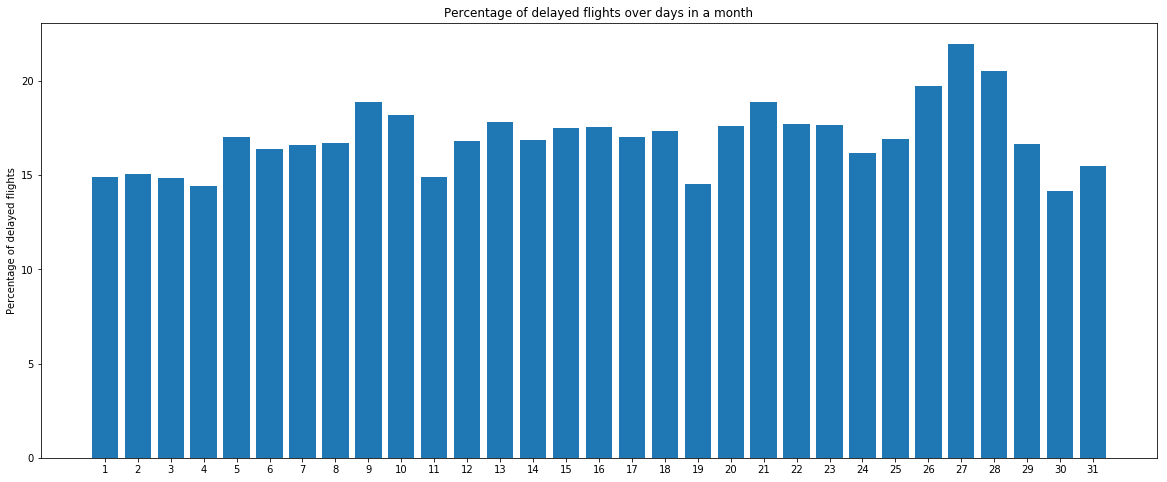

In [18]:
percent = [item[1] for item in percentage_month_delay]
day_of_month = [item[0] for item in percentage_month_delay]
plt.figure(figsize=(20,8))
plt.bar(day_of_month, percent, align="center")
plt.ylabel("Percentage of delayed flights")
plt.title("Percentage of delayed flights over days in a month")
plt.xticks(day_of_month, day_of_month)
plt.show()

<div class="alert alert-info">
    The percentage of delayed flights over days in a month is in the range from 15% to 23%. It is higher in last days of the month (26, 27, 28) but not in the days (29, 30, 31) because not all months have these days. We also notice that after 6 - 7 days we will have a day with low number of delayed flights.
</div>

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [19]:
# number of flights per hour
flights_per_day_of_week = df.groupBy(df.day_of_week).count()

# number of delayed flights for different hours
flights_delay_day_of_week = df[df.arrival_delay >= 15].groupBy(df.day_of_week).count()

percentage_week_delay = (flights_delay_day_of_week.join(flights_per_day_of_week, flights_delay_day_of_week.day_of_week == flights_per_day_of_week.day_of_week, 'inner')
    .select(flights_delay_day_of_week.day_of_week, flights_delay_day_of_week['count']*100/flights_per_day_of_week['count'])
    .orderBy('day_of_week')
    .collect())
                                                         
                                                         

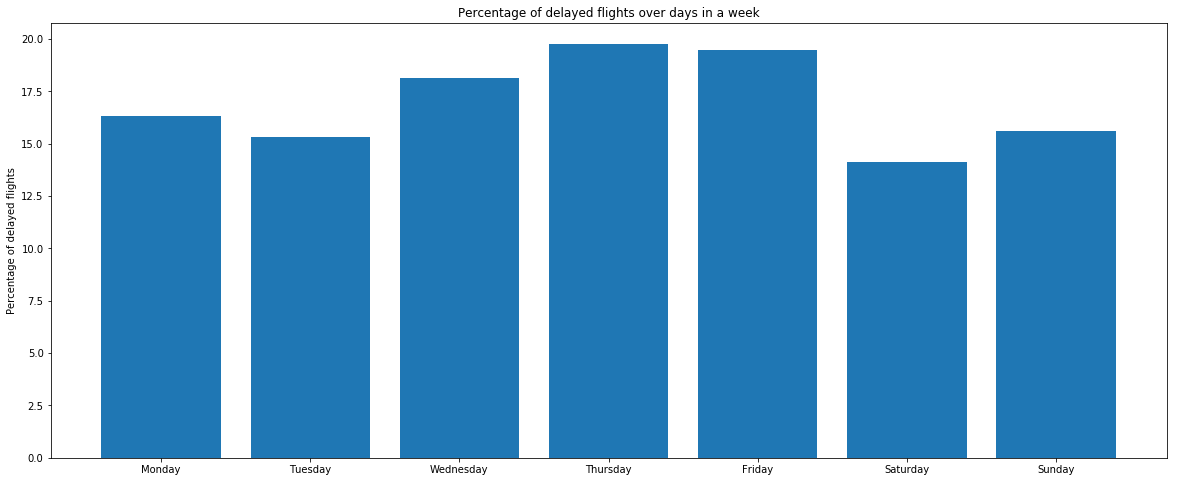

In [22]:
percent = [item[1] for item in percentage_week_delay]
day_of_week = [item[0] for item in percentage_week_delay]
plt.figure(figsize=(20,8))
plt.bar(day_of_week, percent, align="center")
plt.ylabel("Percentage of delayed flights")
plt.title("Percentage of delayed flights over days in a week")
plt.xticks(day_of_week, calendar.day_name[0:7])
plt.show()

<div class="alert alert-info">
    The percentage of delayed flights over days in a week fluctuates around 15% to 20%. It is higher on midle days of week, Wed, Thursday and Friday. 
</div>

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

In [23]:
# number of flights per hour
flights_per_day_of_month = df.groupBy(df.month).count()

# number of delayed flights for different hours
flights_delay_day_of_month = df[df.arrival_delay >= 15].groupBy(df.month).count()

percentage_month_delay = (flights_delay_day_of_month.join(flights_per_day_of_month, flights_delay_day_of_month.month == flights_per_day_of_month.month, 'inner')
    .select(flights_delay_day_of_month.month, flights_delay_day_of_month['count']*100/flights_per_day_of_month['count'])
    .orderBy('month')
    .collect())
                                                         
                                                         

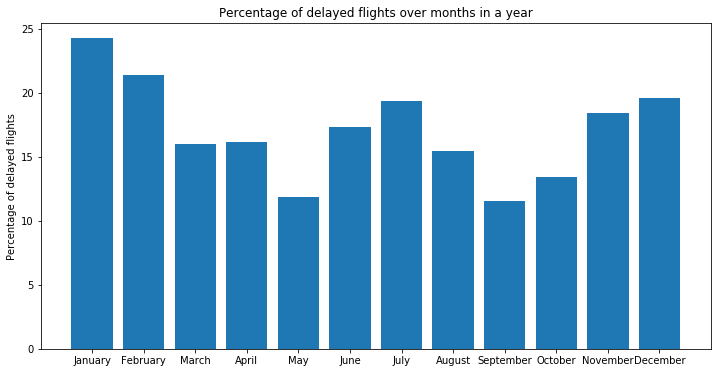

In [24]:
percent = [item[1] for item in percentage_month_delay]
month = [item[0] for item in percentage_month_delay]
plt.figure(figsize=(12, 6))
plt.bar(month, percent, align="center")
plt.ylabel("Percentage of delayed flights")
plt.title("Percentage of delayed flights over months in a year")
plt.xticks(month, calendar.month_name[1:13])
plt.show()

<div class="alert alert-info">
    The percentage of delayed flights over months in a year fluctuates around 12% to 25%. It is higher in November, December, January, February. Maybe it related to the climate in these months. As observed from previous charts, the number of flights per day in summer is high then the percentage of delayed flights also increases.
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [25]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

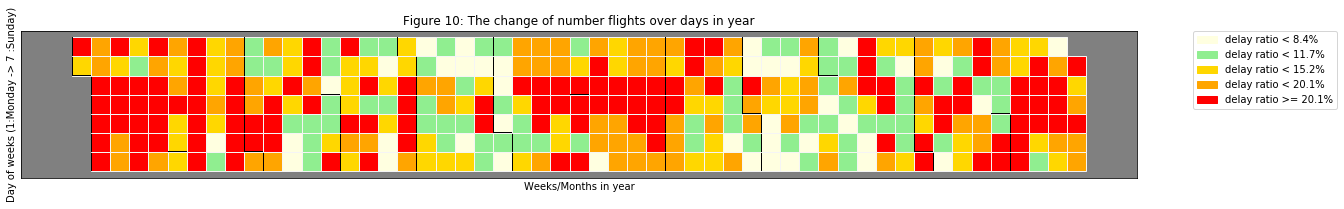

In [26]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class="alert alert-info">
    May and September are very good months for traveling, as the probability of delay is low. However we think this is not also true in France because might be the climate, France vacations are different as well as other conditions can influent to data.
</div>

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [30]:
# count number of flights group by the union airport
df_airport = df.withColumn('airport', df.src_airport).union(df.withColumn('airport', df.dest_airport))

# top 20 busiest airport
top_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)
top20_airport = top_airport.take(20)

#the associated delay of each airport in the top 20 
airport_delay = df_airport.filter(df_airport.airport.isin([x[0] for x in top20_airport]))
airport_delay = airport_delay.withColumn('is_delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
prob_airport_delay = airport_delay.groupBy('airport').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')

#Join the previous dfs based on the the attribute 'airport'
joined_airport_delay = top_airport.join(prob_airport_delay, on='airport').select('*').orderBy('count').collect()

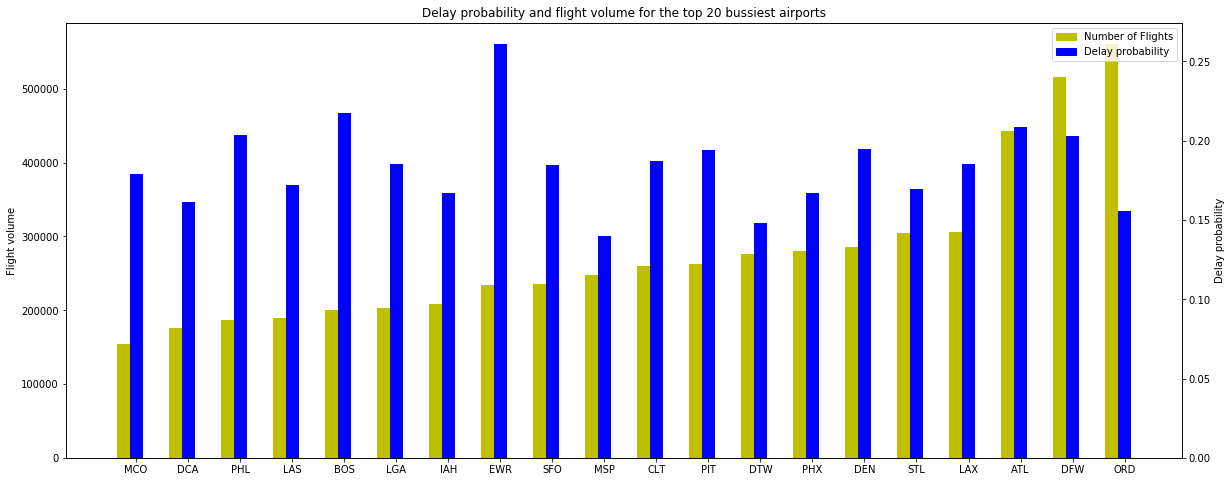

In [31]:
# plot bar chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_airport_delay))], [x[1] for x in joined_airport_delay], 0.25, color = 'y')
ax.set_ylabel('Flight volume')
ax2 = ax.twinx()
bars_delay = (plt.bar([x+0.25 for x in range(len(joined_airport_delay))], 
            [x[2] for x in joined_airport_delay], 0.25, color = 'b'))
ax2.set_ylabel('Delay probability')

dr_patch = mpatches.Patch(color='y', label='Number of Flights')
nf_patch = mpatches.Patch(color='b', label='Delay probability')
plt.legend(handles=[dr_patch,nf_patch])
plt.xticks([x+0.25 for x in range(len(joined_airport_delay))], [x[0] for x in joined_airport_delay])
plt.title('Delay probability and flight volume for the top 20 bussiest airports')
plt.show()

<div class="alert alert-info">
    We can see that there is not a clear correlation between the delay probability and the flight volume in an airport. So we can not give a conclusion about the delays base on the volume of flights. Besides the number of flights, it might dependent on many different factors like the capicity of the airport, the airport quality, the climate, etc.
</div>

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [41]:
top20_busiest_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0).limit(20)
# number of delayed flights for each carrier
df_delayed_per_carrier = df[df.arrival_delay > 15].groupBy(df.carrier).agg(func.count('*').alias('delayed_flights'))

# delayed flights for each of the top 20 busiest carrier
df_delayed_per_busiest_carrier = df_delayed_per_carrier[df_delayed_per_carrier.carrier.isin([x[0] for x in top20_busiest_carriers.collect()])]

# number of delayed flights for each of the 20 top busiest carriers
top20_delay = (
    df_delayed_per_busiest_carrier
    .agg(func.sum('delayed_flights').alias('delayed_flights'))
    .collect()[0].delayed_flights
)

# number of delayed flights
tot_delay = (
    df_delayed_per_carrier
    .agg(func.sum('delayed_flights').alias('delayed_flights'))
    .collect()[0].delayed_flights
)

# percentual of delayed flights of the top 20 carriers over the total number of delayed flights
perc = top20_delay/tot_delay*100
print("The percentage of delayed fights of the 20 top busiest carriers over the total number of flights in delay is " + str(perc) + "%")

The percentage of delayed fights of the 20 top busiest carriers over the total number of flights in delay is 100.0%


In [42]:
# count number of flights group by the carrier
df_carrier = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
# top 20 busiest carrier
top20_carrier = df_carrier.take(20)
carriers_delay = df_with_delay.filter(df_with_delay['carrier'].isin([x[0] for x in top20_carrier]))
carriers_delay = carriers_delay.groupBy('carrier')\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'),
        (func.count('*')).alias('n_flights'))\
    .orderBy('n_flights', ascending=False)

#Join the previous dfs based on the the attribute 'carrier'
joined_carriers_delay = df_carrier.join(carriers_delay, on='carrier').select('*').orderBy('count').collect()


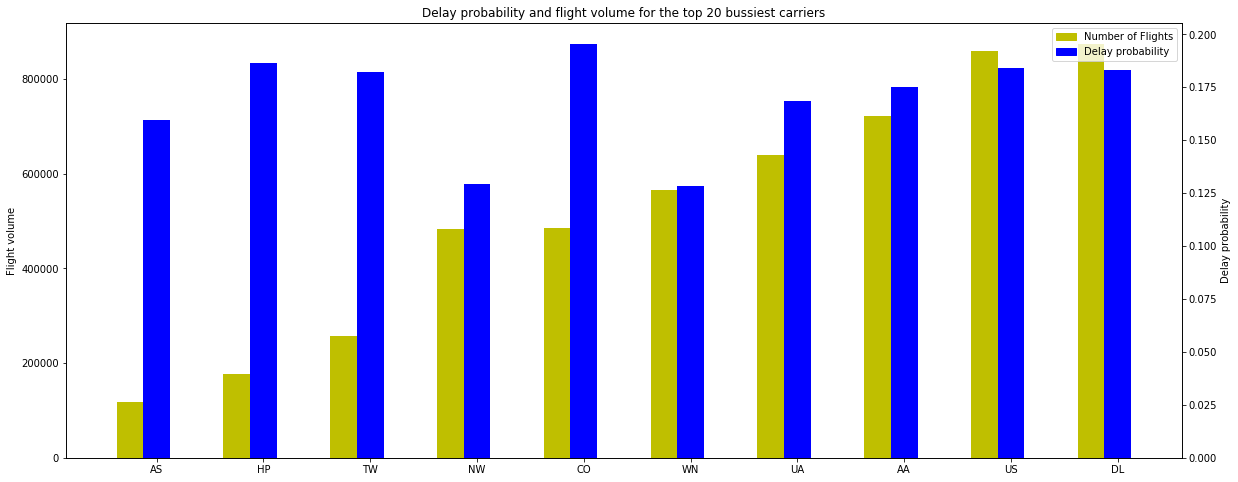

In [43]:
# plot bar chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_carriers_delay))], [x[1] for x in joined_carriers_delay], 0.25, color = 'y')
ax.set_ylabel('Flight volume')
ax2 = ax.twinx()
bars_delay = (plt.bar([x+0.25 for x in range(len(joined_carriers_delay))], 
            [x[2] for x in joined_carriers_delay], 0.25, color = 'b'))
ax2.set_ylabel('Delay probability')

dr_patch = mpatches.Patch(color='y', label='Number of Flights')
nf_patch = mpatches.Patch(color='b', label='Delay probability')
plt.legend(handles=[dr_patch,nf_patch])
plt.xticks([x+0.25 for x in range(len(joined_carriers_delay))], [x[0] for x in joined_carriers_delay])
plt.title('Delay probability and flight volume for the top 20 bussiest carriers')
plt.show()

<div class="alert alert-info">
    We can see that there is not a clear correlation between the delay probability and the flight volume in a carrier. The percentage of delayed flights with carriers which have smaller flight volume like AS, HP, TW is similar to one with large flight volumn like AA, US and DL. Thus, we can not give a conclusion about the delays base on the volume of flights.
</div>

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>



In [44]:
# generate the complete dataframe considering all the csv files in HDFS
all_df = sc.textFile('/datasets/airline/*.csv')
# extract the header
header = all_df.first()

# replace invalid data with NULL and remove header
cleaned_data_all = (
        
        # filter out the header
        all_df.filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns_all = (
    cleaned_data_all.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df_all = sqlContext.createDataFrame(cleaned_data_to_columns_all, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()


df_all.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [72]:
src_airports = df_all.select(df_all.src_airport)
dest_airports = df_all.select(df_all.dest_airport)

# airports present only as destination
dest_not_src = dest_airports.subtract(src_airports)

# airports present only as origin
src_not_dest = src_airports.subtract(dest_airports)
dest_not_src.show()
src_not_dest.show()

+------------+
|dest_airport|
+------------+
|         RCA|
|         LBF|
|         MKC|
|         LAR|
|         CBM|
|         SKA|
+------------+

+-----------+
|src_airport|
+-----------+
+-----------+



There are 6 airports presenting in the dataset only as destination airport and no airports presenting as departure airport only.

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>



In [6]:
df_with_delay = df_all.withColumn('is_delay', func.when(df_all["arrival_delay"] >= 15, 1).otherwise(0))

#Then we group them and mean the delays
print("Top 10 airports that has the highest probability of delays being SOURCES:")
inner_delays=df_with_delay.groupBy('src_airport').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')
inner_delays.show(10)

#Then we group them and mean the delays
print("Top 10 airports that has the highest probability of delays being DESTINATIONS:")
outer_delays=df_with_delay.groupBy("dest_airport").agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio')).orderBy('delay_ratio')
outer_delays.show(10)

#Now we can combine them together and calculate a mean of both arrivals and departures.
print("Top 10 airports that has the highest probability of delays COMBINED:")
combined_delaysdf = pd.DataFrame(inner_delays.collect() + outer_delays.collect())
combined_delaysdf.columns = ['airport','delay_probability']
combined_delays = combined_delaysdf.groupby("airport").mean().sort_values(by="delay_probability",ascending=0)
combined_delays.head(10)

Top 10 airports that has the highest probability of delays being SOURCES:
+-----------+--------------------+
|src_airport|         delay_ratio|
+-----------+--------------------+
|        SPI|                 0.0|
|        TWF|                 0.0|
|        VPS| 0.03168685927306617|
|        BTM| 0.03825136612021858|
|        LSE| 0.04308202154101077|
|        RAP|0.043548387096774194|
|        BIS| 0.06062767475035663|
|        GFK| 0.06132756132756133|
|        LAN| 0.06381226842321944|
|        MOT| 0.06560449859418932|
+-----------+--------------------+
only showing top 10 rows

Top 10 airports that has the highest probability of delays being DESTINATIONS:
+------------+--------------------+
|dest_airport|         delay_ratio|
+------------+--------------------+
|         BFI|                 0.0|
|         TWF|                 0.0|
|         DRO|0.058823529411764705|
|         SUX| 0.08391608391608392|
|         MEM| 0.09676073960795217|
|         BRO|  0.1036077705827937|
|      

,delay_probability
airport,
ACK,0.334091
MTJ,0.333333
GUC,0.283802
EWR,0.261204
BFL,0.258760
PFN,0.258505
SPI,0.250000
BQN,0.248414
JFK,0.247468


### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>


In [70]:
# generate the complete dataframe considering all the csv files in HDFS
delay_weather_df = sc.textFile('/datasets/airline/1994.csv')
# extract the header
#header = all_df.first()

# replace invalid data with NULL and remove header
cleaned_data_all = (
        
        # filter out the header
        delay_weather_df.filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns_all = (
    cleaned_data_all.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df_delay_weather = sqlContext.createDataFrame(cleaned_data_to_columns_all, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)

